In [2]:
import matplotlib
import numpy as np
from keras import losses
from pandas import read_csv
from keras.optimizers import Adam
import dateutil
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
import os
from keras.callbacks import ModelCheckpoint
from pandas import Series
from pandas import DataFrame
from pandas import concat
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"


Using TensorFlow backend.


In [3]:
def parser(x): #date time parser
    return str(dateutil.parser.parse(x).date())+'/' +str(dateutil.parser.parse(x).time())


# CONVERT DATA INTO A SUPERVISED DATA FORM
Taking sequential series of all 'close' values we append another coloumn with corresponsing  i-1 th value of the same sequence.


In [4]:
#helper functions skip to main code

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [5]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
def prepare_data(series, n_test, n_lag, n_seq): #n_test= number of test entries, n_lag number of prev entries analysed, n_seq=number of future predicitons
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

In [6]:
#INVERT TRANSFORMED TO ACTUAL FORM
# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = np.array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]

		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index][1]
		
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

In [7]:
#fetch data
def getData_nex(filename):
    data = pd.read_csv(filename)
    Close = data.close
    data = Close
    scaler, train, test=prepare_data(data,1000,7,1)
    
    xtrain = train[:, 0:7]
    ytrain = train[:,7:]
    xtest = test[:, 0:7]
    ytest = test[:,7:]
    X_train = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1],1))
    
    X_test = np.reshape(xtest, (xtest.shape[0],xtest.shape[1],1))
    return X_train,X_test,ytrain,ytest,scaler

In [8]:
#evaluate forecasts
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		y_true = np.array([row[i] for row in test])
		y_pred = np.array([forecast[i] for forecast in forecasts])
		mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
		rmse=sqrt(mean_squared_error(y_true,y_pred))
		print('t+%d MAPE: %f' % ((i+1), mape))
		print('t+%d RMSE: %f' % ((i+1), rmse))        

In [9]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

In [10]:
############################MAIN STARTS HERE##################
filename='EUR_JPY.csv'
[X_train, X_test, ytrain, ytest,scaler] = getData_nex(filename)

input_tensor = Input((7, 1,))# t, t-1 ....t-6as input
x = input_tensor
rnn_size = 128
W_INIT = 'he_normal'
for i in range(3):#create 3 lstm layers which return a sequqnce of 32, 32*4, 32*8 resp
    x = LSTM(32*2**i,return_sequences=True,
                          go_backwards=True,kernel_initializer=W_INIT)(x)
x=Dropout(0.2)(x)
x=Flatten()(x)
x = Dense(1, activation='linear',kernel_initializer='normal')(x) #final output layer
model = Model(inputs=input_tensor, outputs=x)
adam= Adam(lr=0.05)
#change loss=losses.mean_squared_error for MSE loss
model.compile(loss=losses.mean_squared_error,
              optimizer='adam')

In [11]:
#If you want to save model
#save model's structure
#from keras.utils.vis_utils import plot_model as plot
#from IPython.display import Image
#plot(model, to_file="mBdel.png", show_shapes=True)
#Image('mBdel.png')
#plt.show()

In [12]:
#Checkpoint 
checkpoint_callback = ModelCheckpoint('model.hdf5'
                                      , monitor='val_loss', verbose=0, save_best_only=True,
                                      save_weights_only=False, mode='auto', period=1)

#Fitting Model
model.fit(
    X_train, ytrain,
    batch_size=20, epochs=10,verbose=1,
    initial_epoch = 0,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
3992/3992 [==============================] - 6s 2ms/step - loss: 0.0181
Epoch 2/10
 220/3992 [>.............................] - ETA: 3s - loss: 0.0156

/home/nimish/.local/lib/python3.5/site-packages/keras/callbacks.py:432: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


3992/3992 [==============================] - 3s 827us/step - loss: 0.0173
Epoch 3/10
3992/3992 [==============================] - 3s 819us/step - loss: 0.0173
Epoch 4/10
3992/3992 [==============================] - 3s 849us/step - loss: 0.0171
Epoch 5/10
3992/3992 [==============================] - 4s 968us/step - loss: 0.0172
Epoch 6/10
3992/3992 [==============================] - 4s 971us/step - loss: 0.0171
Epoch 7/10
3992/3992 [==============================] - 4s 1ms/step - loss: 0.0171
Epoch 8/10
3992/3992 [==============================] - 4s 915us/step - loss: 0.0171
Epoch 9/10
3992/3992 [==============================] - 3s 856us/step - loss: 0.0171
Epoch 10/10
3992/3992 [==============================] - 3s 864us/step - loss: 0.0171


t+1 MAPE: 0.076960
t+1 RMSE: 0.150811


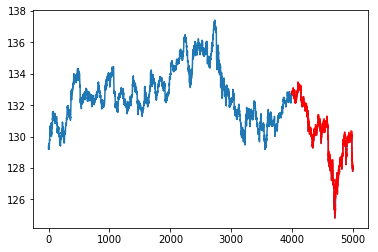

Saved model to disk


In [13]:
#not considering validationdata,might add on later
series=pd.read_csv(filename)
forecasts = model.predict(X_test)
#scaling and inverse helper function
forecasts = inverse_transform(series, forecasts, scaler,1000)
#actual data to compare results with
actual = ytest
actual = inverse_transform(series, actual, scaler, 1000)
evaluate_forecasts(actual, forecasts, 2,1)
#print (series.close.values,forecasts[:5])
series=series.close
plot_forecasts(series, forecasts, 1000)
#saving model if needed for future purposes, coompletely optional rn
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

#print(np.concatenate((forecasts,actual),axis=1))

# Predicts t +1 value using t,t-1,t-2. works reasonably with current configs but on trying to predict t+1 and t+2 both using t,t-1,t-2 it gives all increasing predictions and on increasing dropout to 0.5 it gives inverted V shaped predictions, i.e the t+1 value is increasing and t+2 falls.
#IMO, single step should be practiced on this particular model

In [14]:
%matplotlib qt
plot_forecasts(series, forecasts, 1000)


